# The Boltzmann Banking Model

---

## Overview

This notebook explores a very simple agent-based model of economic activity. The model comprises many individuals that are able to "spend" money by giving some to another individual. They have no preferences as to whom they give their money: this is what makes this a "Boltzmann" model.

For this model, "money" means "bank liabilities" in that each individual has an account at a bank with a balance. When one individual wants to give money to another, the giver simply instructs their bank to "transfer money" to the receiver by reducing their account balance and increasing the recipient's. These accounts are held as liabilities by the bank as a matter of accounting. The money in the accounts originates from loans issued by the banks and held by them as assets.



---

## Notebook Setup

The model is called `BoltzmannBank` and is defined in `model.py`. In addition, we import some plotting functions defined in `econolab.plotting`.

In [1]:
import econolab.plotting as plot

from model import BoltzmannBanking


---

## 0. Model specifications

### Agent Behavior

On their step, individuals have several possible actions....

On their step, banks have only one possible action. They can review loan applications. Each bank has a limit to how many applications it can review on a step. They work through their queue of received applications until the queue is exhausted or they reach their review limit.

### Visualization

...

### Configuration Options

The model can be configured through the following arguments:

+ `num_individuals`: ...
+ `num_banks`: ...
+ ...


---

## 1. Base model: no loans

Let's start with a simulation without any loans. In this model, individuals will be gifted a specifiable amount of money when they first open their account (during the initialization of the model). After that, the only way individuals can get more money is if they receive some from other individuals. The money supply will therefore be constant throughout the simulation.

In [2]:
no_loans_model = BoltzmannBanking(
    num_individuals = 1000,
    init_gift = 5,
)

for _ in range(100):
    no_loans_model.step()

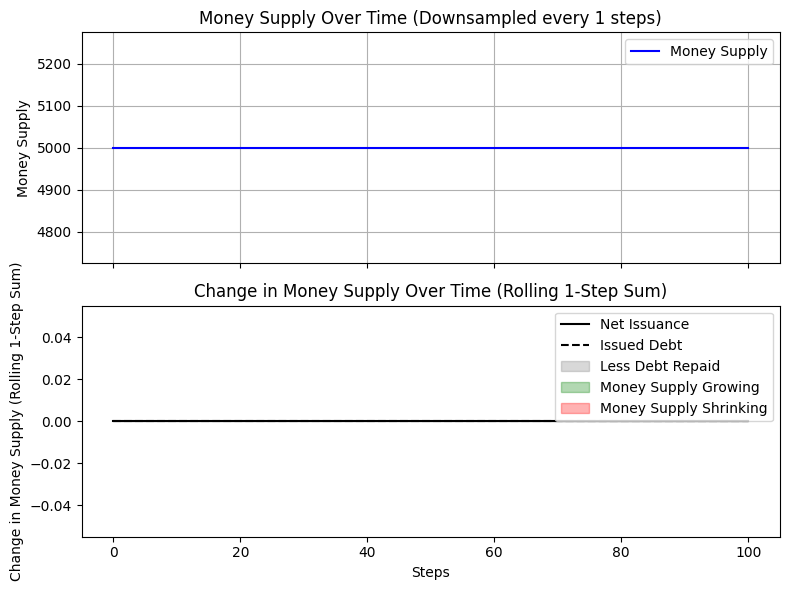

In [3]:
plot.money_supply(no_loans_model)


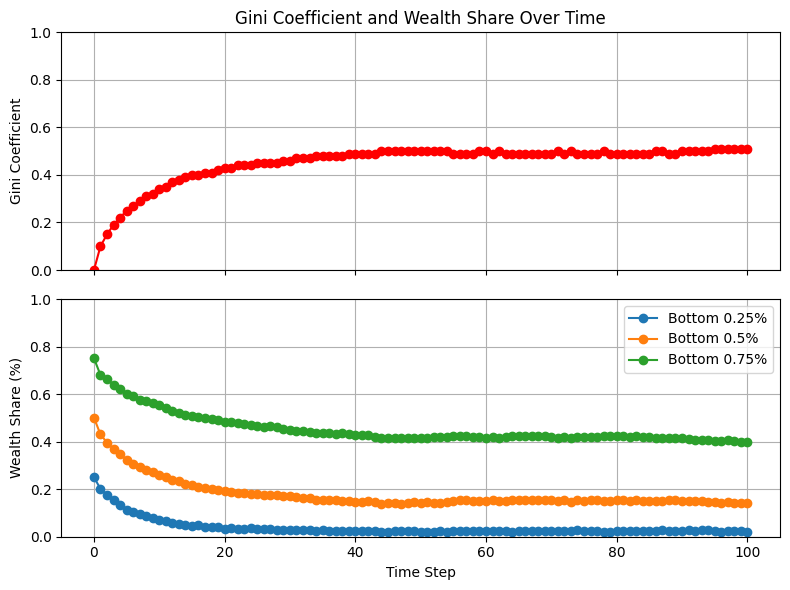

In [4]:
plot.individual_wealth_inequality(no_loans_model)

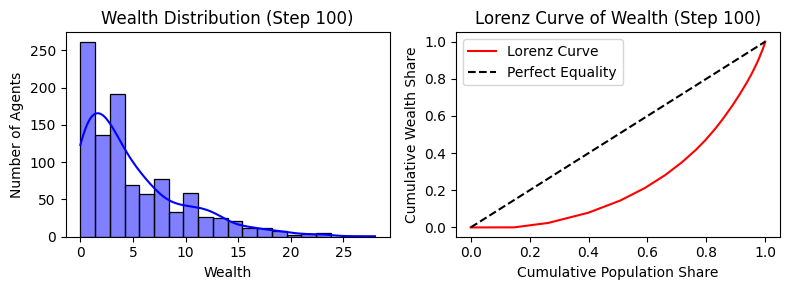

In [5]:
plot.individual_wealth_distribution(no_loans_model)

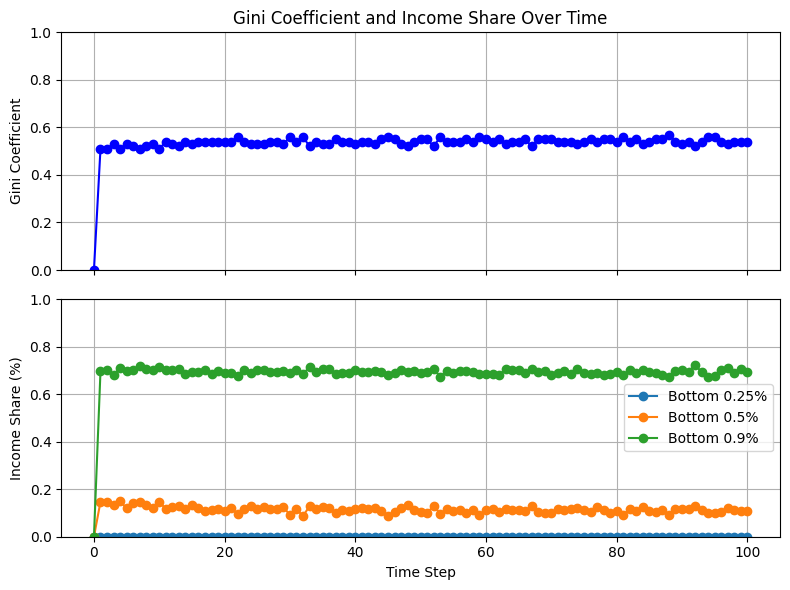

In [6]:
plot.individual_income_inequality(no_loans_model)

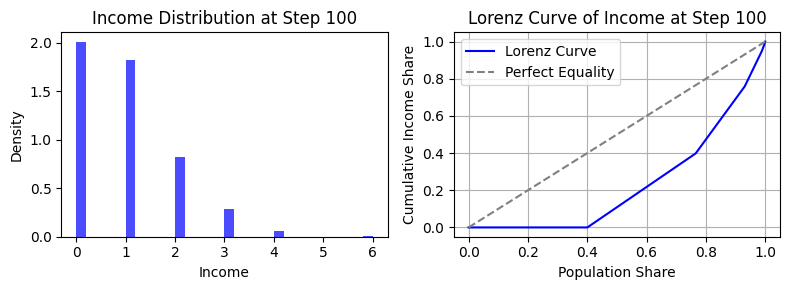

In [7]:
plot.individual_income_distribution(no_loans_model)


---

## 2. A model with loan applications

Now let's allow the bank to issue loans and thereby increase the amount of money available. Each individual will have a personal debt limit that caps the amount that they are willing to borrow. Whenever they don't have enough money to give some away and they are beneath their debt limit, they will apply for a loan from the bank. On its turn, the bank will review some number of loans and will issue liabilities for those it approves. (For now, the bank will approve all loans.)

The principal of the loans will be the minimum of the amount the individual needs for its spending, the amount of debt that they are able to take on, and a configurable maximum amount. The term (ie. duration) of the loan is also configurable.

In [8]:
loan_options = [
    {
        "term": 50,
    },
]

loans_model = BoltzmannBanking(
    num_individuals = 1_000,
    borrowing_limit = 5,
    loan_review_limit = 50,
    loan_options=loan_options,
)

for _ in range(100):
    loans_model.step()

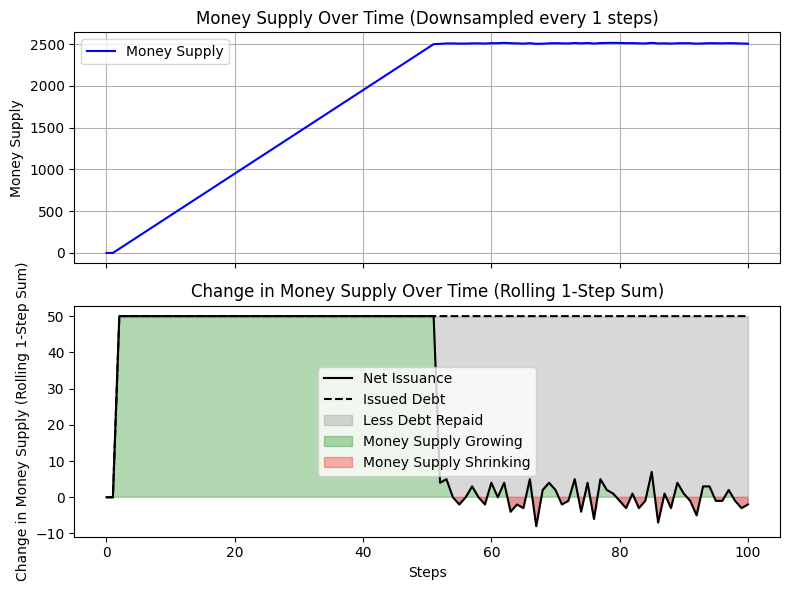

In [9]:
plot.money_supply(loans_model, period=1)

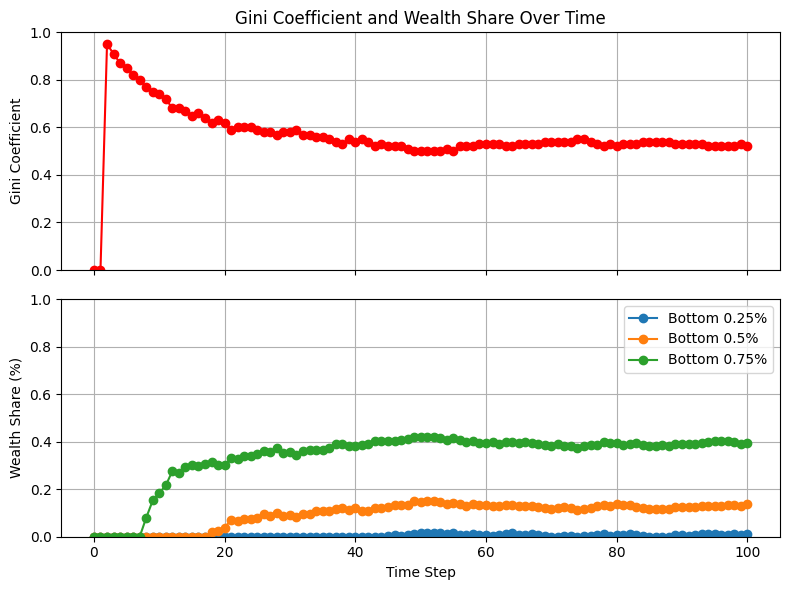

In [10]:
plot.individual_wealth_inequality(loans_model)

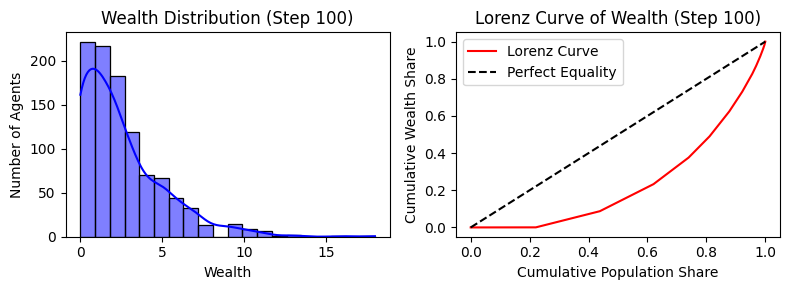

In [11]:
plot.individual_wealth_distribution(loans_model)


---

## 3. A model with multiple banks

Now let's try to expand our model by incorporating multiple banks linked through a reserve bank.

In [12]:
loan_options = [
    {
        "term": 50,
    },
]

multibank_model = BoltzmannBanking(
    num_individuals = 1_000,
    num_banks=10,
    borrowing_limit = 5,
    loan_review_limit = 20,
    loan_options=loan_options,
)

for _ in range(100):
    multibank_model.step()

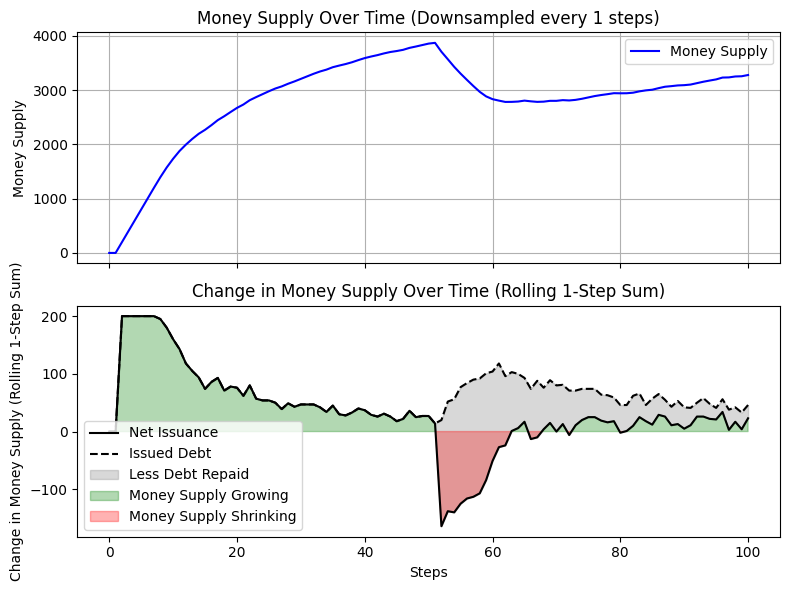

In [13]:
plot.money_supply(multibank_model, period=1)

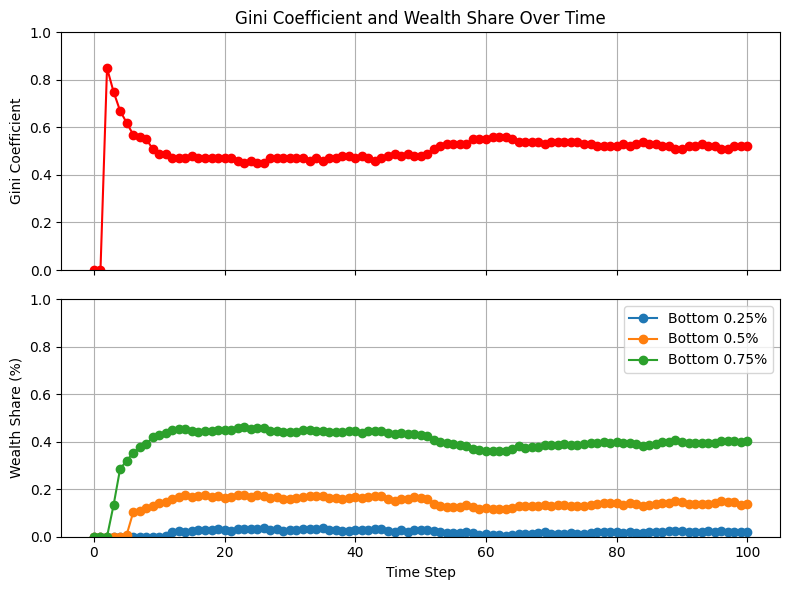

In [14]:
plot.individual_wealth_inequality(multibank_model)

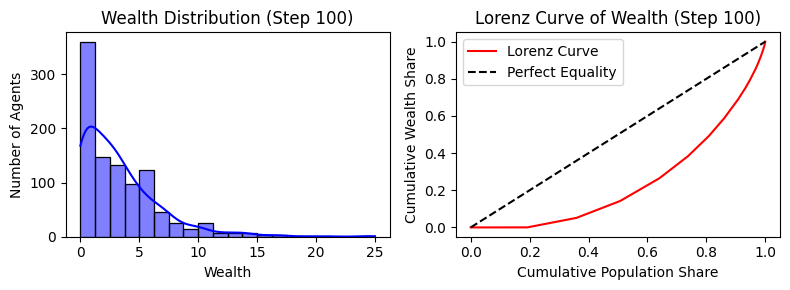

In [15]:
plot.individual_wealth_distribution(multibank_model)